In [137]:
import numpy as np 
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import grad,vmap,jit


In [ ]:
'''Implementation of an SMC sampler for the banana distriubtion using an M-Kernel which is the ULA step described in 
https://arxiv.org/abs/2007.11936. As for small epsilon the kernel is approximately P_t invariant I chose the L-Kernel as the time-reversal
of the M-kernel. Note that due to the invariance of M the weights depend only on the old particles.'''

In [138]:
rng = np.random.default_rng()

b = 5
sigma = 1

@jit
def P(X):
    X = jnp.array(X)
    return jnp.exp(-(X[...,0]**2 + (X[...,1]- b * (X[...,0]**2 - sigma**2)))**2)/2

@jit
def log_P(X):
    X = jnp.array(X)
    return (-(X[...,0]**2 + (X[...,1]- b * (X[...,0]**2 - sigma**2)))**2)/2

##Define the sequence of intermediate targets
beta_t = np.linspace(0,1,20)


In [139]:
def resampling(weights,rng): 

    indices = np.zeros(len(weights),dtype = np.int_) #initialize array to hold the indices
    cdf = np.cumsum(weights)

    u = rng.uniform(0,1/len(weights)) #random number between 1 and 1/n, only drawn once vs the n draws in multinomial resampling
    i = 0
    for j in range(0,len(weights)): 
        r = u + 1/len(weights) * j
        while r > cdf[i]: 
            i += 1
        indices[j] = i

    return indices

In [140]:
particles = jnp.ones((2))
eps = 0.1 
omega = np.eye(2)

val = eps/2 * omega @ grad(P)(particles)

val.shape

(2,)

In [141]:
##Algorithm

#Initial proposal particles
N = 10000
particles = rng.multivariate_normal(np.array([0,0]),10 * np.eye(2),size = (N,))
weights = 1/N * np.ones(N)

beta_t1 = 0
for t,beta in enumerate(beta_t[1:]):

    print(f"Iteration: {t}")

    #Resampling step
    indices = resampling(weights,rng)
    particles = particles[indices,:]

    old_particles = particles.copy()
    
    #Mutation/M-Kernel step
    eps = 0.01
    omega = np.eye(2)
    cov_sqrt = np.linalg.cholesky(eps * omega)

    std_variates = rng.multivariate_normal(mean = np.zeros(2),cov=np.eye(2), size = (N,))
    particles += (eps/2 * omega @ vmap(grad(log_P),in_axes = 0)(particles).T).T + std_variates @ cov_sqrt
    
    #Compute weights
    weights = (P(old_particles)**beta)/(P(old_particles)**beta_t1)

    # #Normalize weights
    weights /= np.sum(weights)

    # #Track the previous beta
    beta_t1 = beta

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18


In [142]:
indices = resampling(weights,rng)
particles = particles[indices,:]

mean_estimate = np.mean(particles,axis = 0)
cov_estimate = np.cov(particles.T)

print(f"Estimate of the mean: {mean_estimate}")
print(f"Estimate of the Cov: {cov_estimate}")

Estimate of the mean: [ 0.01203381 -1.0112307 ]
Estimate of the Cov: [[ 0.98340405 -0.05812417]
 [-0.05812417  7.59042693]]


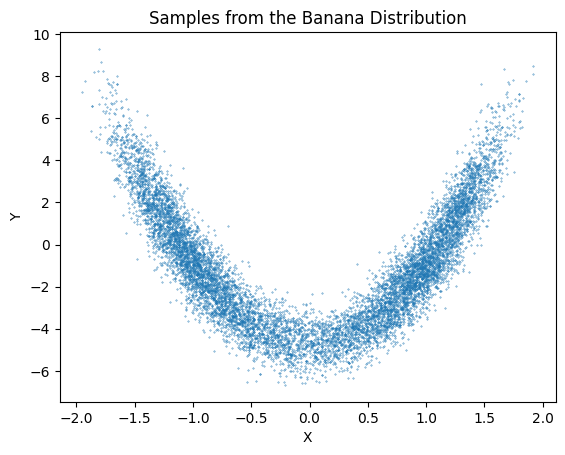

In [143]:
plt.title('Samples from the Banana Distribution')
plt.xlabel('X')
plt.ylabel('Y')

plt.scatter(particles[:,0],particles[:,1],s = 0.1)